<a href="https://www.kaggle.com/code/mohammadalnajdawi/alexnet-model-mayo-clinic?scriptVersionId=101663883" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Library

In [1]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import IPython.display

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from PIL import Image
from glob import glob
import scipy as sp
import numpy as np
import pandas as pd
#import Pyvips

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, regionprops_table
from sklearn.preprocessing import StandardScaler
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle



from tqdm.auto import tqdm
from tqdm import trange
from time import sleep
from functools import partial
import tifffile as tiff

import cv2 as cv
from openslide import OpenSlide
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import torchvision.transforms as transforms
import torch.optim as optim
import gc

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

from torch.cuda.amp import autocast, GradScaler
Image.MAX_IMAGE_PIXELS = None
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading data

In [2]:
train_data = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
transformed_train = pd.read_csv('../input/mayo-clinic-output/new_train.csv')
train_data['enc_label'] = np.where(train_data['label']== 'CE', 1, 0)
train, vaild = train_test_split(train_data, test_size=0.204)
test = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
sample_sub = pd.read_csv('../input/mayo-clinic-strip-ai/sample_submission.csv')


# EDA

In [3]:
print(train.head())


     image_id  center_id patient_id  image_num label  enc_label
422  8e0684_0          4     8e0684          0    CE          1
62   113bb3_0          8     113bb3          0   LAA          0
408  86e319_2          7     86e319          2    CE          1
660  e3e850_0         11     e3e850          0   LAA          0
642  deec71_0         10     deec71          0   LAA          0


In [4]:
patients_train = train['patient_id'].nunique()
patients_test = test['patient_id'].nunique()
print(f"Number of unique patient {patients_train}")


Number of unique patient 522


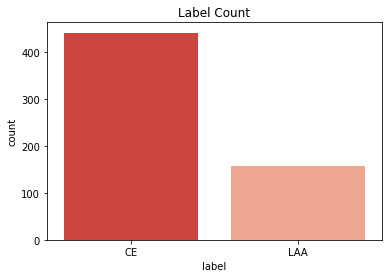

In [5]:
sns.countplot(train.label, palette="Reds_r")
plt.title("Label Count");

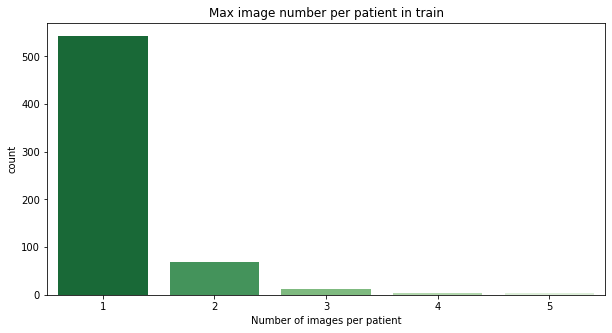

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(train_data.groupby("patient_id").image_num.size(), palette="Greens_r")
plt.xlabel("Number of images per patient")
plt.title("Max image number per patient in train");


# Image Transformation 

In [7]:
def rezie_image(image):
    resized_image = cv.resize(image,(int(image.shape[1]/33),int(image.shape[0]/33)),interpolation= cv.INTER_LINEAR)
    return resized_image

In [8]:
def grey_resize(image):
    gray_resized_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)    
    return gray_resized_image

In [9]:
def labeled_segment(grey_resized_image):
    elevation_map = sobel(grey_resized_image)
    markers = np.zeros_like(grey_resized_image)
    markers[grey_resized_image >= grey_resized_image.mean()] = 1
    markers[grey_resized_image < grey_resized_image.mean()] = 2
    segmented_img = segmentation.watershed(elevation_map, markers)
    filled_segments = ndi.binary_fill_holes(segmented_img - 1)
    labeled_segments, _ = ndi.label(filled_segments)
    return labeled_segments


In [10]:
def plot_labeled_segments(labeled_segments, resized_gray_img):
    image_label_overlay = label2rgb(labeled_segments, image=resized_gray_img, bg_label=0)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image_label_overlay, cmap=plt.cm.gray)
    ax.set_title('segmentation')
    ax.axis('off')


In [11]:
def get_object_coordinates(labeled_segments):
    properties =['area','bbox','convex_area','bbox_area', 'major_axis_length', 'minor_axis_length', 'eccentricity']
    df = pd.DataFrame(regionprops_table(labeled_segments, properties=properties))
    standard_scaler = StandardScaler()
    scaled_area = standard_scaler.fit_transform(df.area.values.reshape(-1,1))
    df['scaled_area'] = scaled_area
    df.sort_values(by="scaled_area", ascending=False, inplace=True)
    objects = df[df['scaled_area']>=.75]
    object_coordinates = [(row['bbox-0'],row['bbox-1'],row['bbox-2'],row['bbox-3'] )for index, row in objects.iterrows()]
    return object_coordinates


In [12]:
def plot_object_coordinates(object_coordinates, resized_image):
    fig, ax = plt.subplots(1,1, figsize=(18, 16), dpi = 80)
    for blob in object_coordinates:
        width = blob[3] - blob[1]
        height = blob[2] - blob[0]
        patch = Rectangle((blob[1],blob[0]), width, height, edgecolor='r', facecolor='none')


In [13]:
def save_objects(object_coordinates, image, image_name, label, count):
    plt.figure(figsize=(10,18))
    for i in range(len(object_coordinates)):
        coordinates = object_coordinates[i]
        object_image = image[int(coordinates[0]):int(coordinates[2]), int(coordinates[1]):int(coordinates[3])]
        #plt.imshow(object_image)
        image_new_name = image_name + "_" + str(i)
        new_train["image_name"].append(image_new_name)
        new_train["label"].append(label)
        new_train["image_count"].append(count)
        cv.imwrite(os.path.join("./", f"{image_new_name}.jpg"), object_image)
        



In [14]:
"""train_path = "../input/mayo-clinic-strip-ai/train"
Image_names = train['image_id'].values
new_train={"image_count":[],"image_name":[],"label":[]}
count=1
scale = 4
for image_name in Image_names:
    Image_label = train.loc[train['image_id'] == image_name, 'enc_label'].iloc[0]
    image = tiff.imread(os.path.join(train_path, f"{image_name}.tif"))
    resized_image=rezie_image(image)
    del image
    gc.collect()
    grey_resized_image = grey_resize(resized_image)
    labeled_segments = labeled_segment(grey_resized_image)
    object_coordinates = get_object_coordinates(labeled_segments)
    save_objects(object_coordinates, resized_image, image_name, Image_label,count)
    count+=1
    #if count == 80:
    #    break
new_train=pd.DataFrame.from_dict(new_train)"""

'train_path = "../input/mayo-clinic-strip-ai/train"\nImage_names = train[\'image_id\'].values\nnew_train={"image_count":[],"image_name":[],"label":[]}\ncount=1\nscale = 4\nfor image_name in Image_names:\n    Image_label = train.loc[train[\'image_id\'] == image_name, \'enc_label\'].iloc[0]\n    image = tiff.imread(os.path.join(train_path, f"{image_name}.tif"))\n    resized_image=rezie_image(image)\n    del image\n    gc.collect()\n    grey_resized_image = grey_resize(resized_image)\n    labeled_segments = labeled_segment(grey_resized_image)\n    object_coordinates = get_object_coordinates(labeled_segments)\n    save_objects(object_coordinates, resized_image, image_name, Image_label,count)\n    count+=1\n    #if count == 80:\n    #    break\nnew_train=pd.DataFrame.from_dict(new_train)'

# Data Loader

In [15]:
class TrainDataset(Dataset):
    def __init__(self, path, df, transform=None):
        self.df = df
        self.path = path
        self.Image_names = df['image_name'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.Image_names[idx]
        img= Image.open(os.path.join(self.path, f"{file_name}.jpg"))
        if self.transform:
            image=self.transform(img)

        label = self.labels[idx]

        return image, torch.tensor(label)

# Transforms

In [16]:
batch_size=64
data_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = TrainDataset("../input/mayo-clinic-output/", transformed_train, transform = data_transform)
#vaild_dataset = TrainDataset("../input/mayo-clinic-strip-ai/train", vaild, transform = data_transform)
#test_dataset = TrainDataset("../input/mayo-clinic-strip-ai/train", test, transform = data_transform)

dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=0)
#dataset_loader_vaild = torch.utils.data.DataLoader(vaild_dataset,
#                                             batch_size=batch_size, shuffle=True,
#                                             num_workers=0)


# Binary accuracy metric

In [17]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc


# AlexNet Model

In [18]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=1)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training 

In [19]:
"""model = AlexNet()
#model = VGG16()
model = model.to(device=device)
print(device)
## Loss and optimizer
learning_rate = 1e-3 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning
for epoch in range(10): #I decided to train the model for 5 epochs
    with tqdm(dataset_loader, unit="batch") as tepoch:
        e=epoch+1
        loss_ep = 0
        epoch_acc = 0

        for (data, targets) in (tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            
            data = data.to(device=device).requires_grad_(True)
            targets = targets.type(torch.FloatTensor).to(device=device).requires_grad_(True)
            optimizer.zero_grad()
            y_pred = model(data)
            sco = torch.clamp(y_pred,0,1)
            loss = criterion(sco.squeeze(),targets)
            acc = binary_acc(sco.squeeze(),targets)
            loss.backward()
            optimizer.step()
            loss_ep += loss.item()
            epoch_acc += acc.item()
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * acc.item())
            sleep(0.1)
    print(f'Epoch {e+0:03}: | Loss: {loss_ep/len(dataset_loader):.5f} | Acc: {epoch_acc/len(dataset_loader):.3f}')

        
   """

'model = AlexNet()\n#model = VGG16()\nmodel = model.to(device=device)\nprint(device)\n## Loss and optimizer\nlearning_rate = 1e-3 #I picked this because it seems to be the most used by experts\nload_model = True\ncriterion = nn.BCELoss()\noptimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning\nfor epoch in range(10): #I decided to train the model for 5 epochs\n    with tqdm(dataset_loader, unit="batch") as tepoch:\n        e=epoch+1\n        loss_ep = 0\n        epoch_acc = 0\n\n        for (data, targets) in (tepoch):\n            tepoch.set_description(f"Epoch {epoch}")\n            \n            data = data.to(device=device).requires_grad_(True)\n            targets = targets.type(torch.FloatTensor).to(device=device).requires_grad_(True)\n            optimizer.zero_grad()\n            y_pred = model(data)\n            sco = torch.clamp(y_pred,0,1)\n            loss = criterion(sco.squeeze(),targets)\n            acc = binar

In [20]:
"""with torch.no_grad():
        num_correct = 0
        num_samples = 0
        
        for batch_idx, (data,targets) in enumerate(dataset_loader_vaild):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )"""

'with torch.no_grad():\n        num_correct = 0\n        num_samples = 0\n        \n        for batch_idx, (data,targets) in enumerate(dataset_loader_vaild):\n            data = data.to(device=device)\n            targets = targets.to(device=device)\n            ## Forward Pass\n            scores = model(data)\n            _, predictions = scores.max(1)\n            num_correct += (predictions == targets).sum()\n            num_samples += predictions.size(0)\n        print(\n            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"\n        )'

In [21]:
import torchvision.models as models
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = models.vgg16(pretrained=True)
model_ft=model_ft.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [22]:
num_ftrs = model_ft.classifier[0].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
#model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        with tqdm(dataset_loader, unit="batch") as tepoch:
            e=epoch+1
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / len(dataset_loader)
                epoch_acc = running_corrects.double() / len(dataset_loader)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                # deep copy the model
            print()
            tepoch.set_postfix(loss=loss.item())
            sleep(0.1)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 0/24
----------
train Loss: 66.2987 Acc: 38.8554
val Loss: 41.6943 Acc: 42.4819



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 1/24
----------
train Loss: 40.3326 Acc: 42.6265
val Loss: 40.4518 Acc: 44.1687



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 2/24
----------
train Loss: 39.8296 Acc: 42.7831
val Loss: 37.6806 Acc: 43.9759



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 3/24
----------
train Loss: 39.2430 Acc: 43.2771
val Loss: 37.3467 Acc: 43.8554



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 4/24
----------
train Loss: 38.2732 Acc: 43.2651
val Loss: 36.6241 Acc: 44.6024



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 5/24
----------
train Loss: 38.0882 Acc: 43.7590
val Loss: 39.7453 Acc: 44.2048



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 6/24
----------
train Loss: 37.3439 Acc: 44.1687
val Loss: 35.1005 Acc: 45.6627



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 7/24
----------
train Loss: 35.7291 Acc: 44.8675
val Loss: 34.5266 Acc: 45.7952



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 8/24
----------
train Loss: 35.3483 Acc: 45.2530
val Loss: 34.2676 Acc: 46.1928



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 9/24
----------
train Loss: 34.9619 Acc: 45.7590
val Loss: 34.2453 Acc: 45.7831



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 10/24
----------
train Loss: 34.7370 Acc: 45.8795
val Loss: 33.8660 Acc: 46.2892



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 11/24
----------
train Loss: 34.6946 Acc: 45.5663
val Loss: 33.8368 Acc: 46.4578



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 12/24
----------
train Loss: 34.3418 Acc: 46.3614
val Loss: 33.4508 Acc: 46.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 13/24
----------
train Loss: 34.3351 Acc: 45.9277
val Loss: 33.6086 Acc: 47.2530



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 14/24
----------
train Loss: 33.9663 Acc: 46.3253
val Loss: 33.1826 Acc: 46.9759



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 15/24
----------
train Loss: 34.0267 Acc: 46.3494
val Loss: 33.2015 Acc: 47.1446



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 16/24
----------
train Loss: 33.9239 Acc: 46.4217
val Loss: 33.1293 Acc: 47.0120



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 17/24
----------
train Loss: 33.9673 Acc: 46.5181
val Loss: 33.1417 Acc: 47.1205



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 18/24
----------
train Loss: 33.7072 Acc: 46.4337
val Loss: 33.0731 Acc: 47.0843



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 19/24
----------
train Loss: 33.8720 Acc: 46.6627
val Loss: 33.0785 Acc: 47.0843



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 20/24
----------
train Loss: 33.7208 Acc: 46.5422
val Loss: 33.0410 Acc: 46.9880



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 21/24
----------
train Loss: 33.4788 Acc: 46.8675
val Loss: 33.0364 Acc: 46.9759



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 22/24
----------
train Loss: 33.6291 Acc: 46.4699
val Loss: 33.0210 Acc: 46.9518



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 23/24
----------
train Loss: 33.4878 Acc: 46.6867
val Loss: 33.0158 Acc: 46.9518



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 24/24
----------
train Loss: 33.5782 Acc: 46.7831
val Loss: 33.0107 Acc: 46.9759

Training complete in 51m 39s
